In [64]:
import csv
import re

letters_data_file = 'zwingli_letters.txt'
output_csv_file = 'letter_connections.csv'
letter_connections = {}
pattern = r"Nr.\s*(\d+[a-z]?)\s*([\w\s\(\).]+?)\s*\ban\s*([\w\s\(\).,]+?)\s*-([\w\s\(\).,?\<\>/-]*)?,\s*([\w\s\(\).IVXLCDM?]+)"

with open(letters_data_file, 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            number = match.group(1).strip()
            sender = match.group(2).strip().replace('(', '').replace(')', '').strip()
            receiver = match.group(3).strip().replace('(', '').replace(')', '').strip()
            city = match.group(4).replace('<', '').replace('>', '').replace('(', '').replace(')', '').strip()
            date = match.group(5).replace('(', '').replace(')', '').strip()
            # Note the change to set(sender, receiver) here
            connection = frozenset([sender, receiver])
            if connection in letter_connections:
                letter_connections[connection] += 1
            else:
                letter_connections[connection] = 1
        else:
            print(f"Pattern not found in line: {line}")

# Write letter connections to a CSV file
with open(output_csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Sender', 'Receiver', 'Count'])
    for connection, count in letter_connections.items():
        sender, receiver = list(connection)
        writer.writerow([sender, receiver, count])

print(f"Data saved to '{output_csv_file}' CSV file.")


Pattern not found in line: Nr. 119 Ulrich Zasius an Zwingli, Freiburg im Breisgau, 16 II 1520

Pattern not found in line: Nr. 139 Valentin Curio an Zwingli <place>Basel, 16 V 1520

Pattern not found in line: Nr. 159 Johann Jakob Ammann an Zwingli Mailand, 27 X (1520)

Pattern not found in line: Nr. 199 Zwingli an Beatus Rhenanus, Zürich, 25 III 1522

Pattern not found in line: Nr. 246 Michael Hummelberg an Zwingli, Ravensburg, 2 XI 1522

Pattern not found in line: Nr. 334 Zwingli an (Konrad) (Hofmann?) - (Zürich), 30 IV (1524?)

Pattern not found in line: Nr. 433 Winterthur, Schultheiss und Räte an Zwingli - Winterthur, (1526 ff.?)

Pattern not found in line: Nr. 517 Zwingli an Ambrosius(?) Blarer oder an Thomas(?) Blarer - Zürich, 11 VIII 1526

Pattern not found in line: Nr. 622 Zwingli an Johannes Haner (?) - (Zürich), (V f. 1527)

Pattern not found in line: Nr. 631 Zürich, Kanzlei an Zwingli - (Zürich), 26 VI 1527

Pattern not found in line: Nr. 653 N.N. an Zwingli(?) - s. l., 9 IX 

In [44]:
import networkx as nx
import pandas as pd

# Read the CSV file
df = pd.read_csv('letter_connections.csv')

# Create an empty graph
G = nx.Graph()

# Add nodes (senders and receivers) with their corresponding counts
for _, row in df.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    count = row['Count']
    G.add_edge(sender, receiver, weight=count)


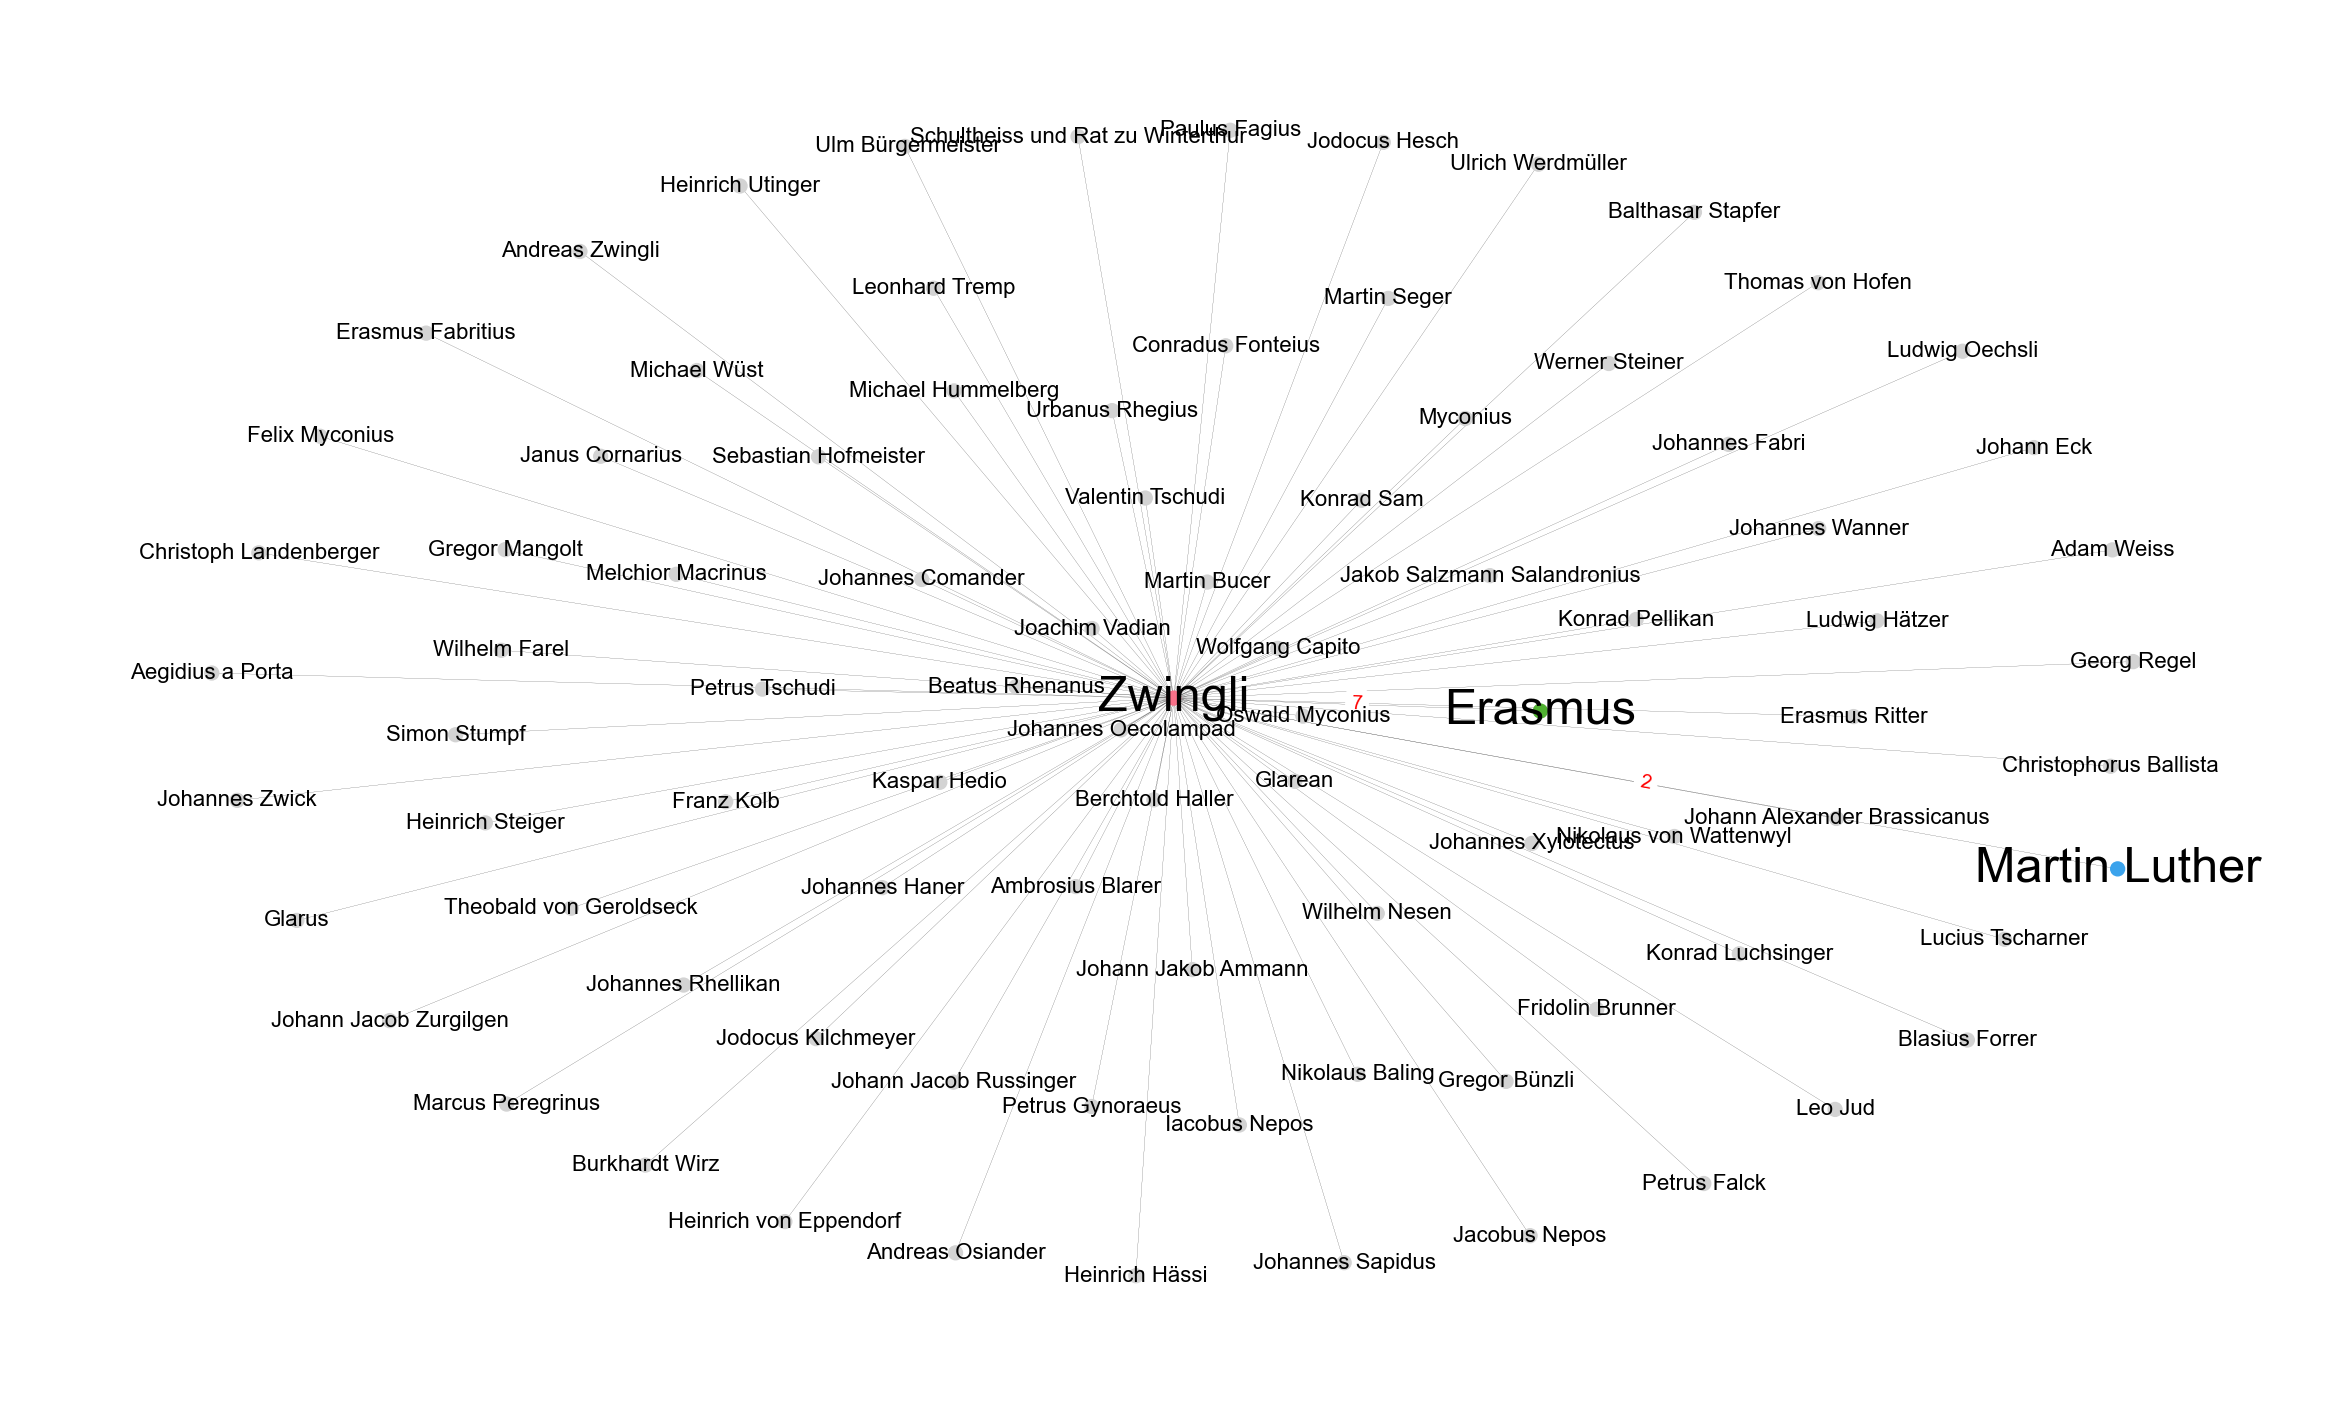

In [61]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Use Seaborn styles for more modern looking plots
sns.set_style("white")


mpl.rc('font', family='DejaVu Sans', size=10)

# Read the CSV file
df = pd.read_csv('letter_connections.csv')

# Create an empty graph
G = nx.Graph()

# Add nodes (senders and receivers) with weighted edges based on count
for _, row in df.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    count = row['Count']
    if count > 1:
        G.add_edge(sender, receiver, weight=count)

# Create a subgraph centered on Zwingli
center = 'Zwingli'
subgraph = nx.ego_graph(G, center, radius=1)

# Set the size of the plot
plt.figure(figsize=(30, 18))

# Set the position of nodes based on spring layout with weight reflecting counts
# Increase the scale parameter to spread nodes more randomly
pos = nx.spring_layout(subgraph, weight='weight', scale=2)

# Draw the edges with a thinner width
nx.draw_networkx_edges(subgraph, pos, width=0.1)

# Specify nodes for 'Zwingli', 'Erasmus', and 'Martin Luther' with a different color
special_nodes = [node for node in ['Zwingli', 'Erasmus', 'Martin Luther'] if node in subgraph.nodes()]
special_colors = {node: color for node, color in zip(special_nodes, sns.color_palette("husl", len(special_nodes))) if node in subgraph.nodes()}

other_colors = 'lightgray'
# Draw the nodes
nx.draw_networkx_nodes(subgraph, pos, node_color=[special_colors.get(node, other_colors) for node in subgraph.nodes()], node_size=100)

# Draw the edges with thinner lines
nx.draw_networkx_edges(subgraph, pos, width=0.1, alpha=0.2)

# Draw the special labels with a larger font size
nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in special_nodes if node in subgraph.nodes()}, font_size=35)

# Draw the other labels with a smaller font size
nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in subgraph.nodes() if node not in special_nodes}, font_size=16)


# Get the edge labels for the edges connecting 'Zwingli', 'Erasmus', and 'Martin Luther'
edge_labels = {(center, node): subgraph.edges[center, node]['weight'] for node in special_nodes if subgraph.has_edge(center, node)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=14)

plt.axis('off')

# Show the plot
plt.show()


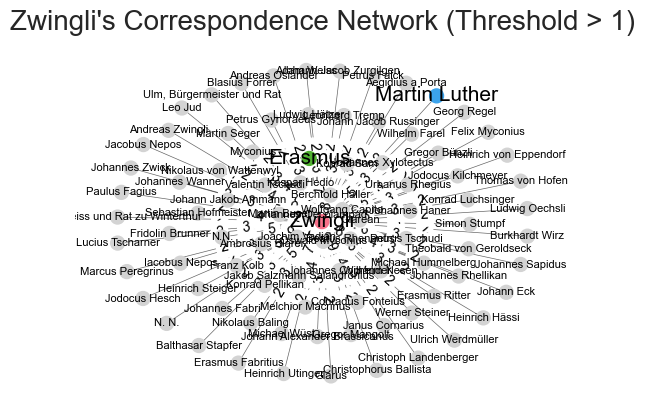

<Figure size 3000x3000 with 0 Axes>

In [39]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn styles for more modern looking plots
sns.set_style("white")

# Read the CSV file
df = pd.read_csv('letter_connections.csv')

# Create an empty graph
G = nx.Graph()

# Add nodes (senders and receivers) with weighted edges based on count
for _, row in df.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    count = row['Count']
    if count > 1:
        G.add_edge(sender, receiver, weight=count)

# Create a subgraph centered on Zwingli
center = 'Zwingli'
subgraph = nx.ego_graph(G, center, radius=1)

# Set the position of nodes based on spring layout with weight reflecting counts
pos = nx.spring_layout(subgraph, weight='weight', seed=42, k=0.5)

# Specify labels for certain nodes with a larger font size
special_nodes = ['Zwingli','Erasmus', 'Martin Luther']
special_colors = {node: color for node, color in zip(special_nodes, sns.color_palette("husl", len(special_nodes))) if node in subgraph.nodes()}

# Color for other nodes
other_colors = 'lightgray'

# Draw the nodes
nx.draw_networkx_nodes(subgraph, pos, node_color=[special_colors.get(node, other_colors) for node in subgraph.nodes()], node_size=100)

# Draw the edges with thinner lines
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.6)

# Draw the special labels with a larger font size
nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in special_nodes if node in subgraph.nodes()}, font_size=15)

# Draw the other labels with a smaller font size
nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in subgraph.nodes() if node not in special_nodes}, font_size=8)

# Draw edge labels for special nodes
for node in special_nodes:
    if node in subgraph:
        weights = nx.get_edge_attributes(subgraph, 'weight')
        labels = {edge: weights[edge] for edge in weights if node in edge}
        nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)

# Set the title
plt.title(f"Zwingli's Correspondence Network (Threshold > 1)", fontsize=20)

# Remove axes for a cleaner look
plt.axis('off')

# Set figure size
plt.figure(figsize=(30,30))

# Show the plot
plt.show()


In [45]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")


Number of nodes: 281
Number of edges: 277


In [46]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Print degree centrality for each node
for node, centrality in degree_centrality.items():
    print(f"Degree centrality of {node}: {centrality}")


Degree centrality of Glarean: 0.0035714285714285713
Degree centrality of Zwingli: 0.9535714285714285
Degree centrality of Joachim Vadian: 0.0035714285714285713
Degree centrality of Johann Heinrich Wentz: 0.0035714285714285713
Degree centrality of Jakob Zwingli: 0.0035714285714285713
Degree centrality of Valentin Tschudi: 0.0035714285714285713
Degree centrality of Johannes Dingnauer: 0.0035714285714285713
Degree centrality of Petrus Falck: 0.0035714285714285713
Degree centrality of Erasmus: 0.0035714285714285713
Degree centrality of Nesenus: 0.0035714285714285713
Degree centrality of Petrus Tschudi: 0.0035714285714285713
Degree centrality of Aegidius Tschudi: 0.0035714285714285713
Degree centrality of Sigismund Rötlin: 0.0035714285714285713
Degree centrality of Johann Leupold Konrad Grebel: 0.0035714285714285713
Degree centrality of Jakob Salzmann (Salandronius): 0.0035714285714285713
Degree centrality of Schultheiss und Rat zu Winterthur: 0.0035714285714285713
Degree centrality of Conr

In [47]:
# Perform community detection using Louvain algorithm
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

# Print the communities
for i, community in enumerate(communities, start=1):
    print(f"Community {i}: {community}")


Community 1: frozenset({'Johann Heinrich Wentz', 'Johannes Zwick', 'Alexander Grat', 'Ulrich Kölbiner', 'Glarus', 'Margaretha von Wattenwyl', 'Johannes Oecolampad an Basel, Prediger', 'Kaspar Hedio', 'Martin Seger', 'Bartholomäus Stocker', 'Joachim vom Grüt', 'Johannes Oecolampad Bonifatius Wolfhart', 'Berchtold Haller', 'Petrus Falck', 'Erasmus Fabritius', 'Philippus Engentinus', 'Nikolaus Baling', 'Melchior Macrinus', 'Sigismund Rötlin', 'Gregor Bünzli', 'Hieronymus Frobenius', 'Valentinus de Saxonia', 'Heinrich Utinger', 'N. N.', 'Bombasius', 'Johannes Xylotectus', 'Glarus, Schaffhausen und Appenzell', '(Heinrich) (Steiger)', 'Wilhelm Farel', 'Ludwig Oechsli', 'Hans Gebentinger', 'Christoph Landenberger', 'Wilibald Pirkheimer', 'Konrad Luchsinger', 'Johannes Gebentinger', 'Toggenburg', 'Bern, Brüder', 'Benedikt Schütz', 'Botschaften, eidgenössische', 'Alexander Sytz', 'Petrus Tschudi', 'Ulrich Zasius', 'Ludwig Hätzer', 'Balthasar Hubmaier', 'Wolfgang Capito und an Martin Bucer', 'Ul

In [36]:
import pandas as pd
import re

# Define lists to store the data
numbers = []
senders = []
receivers = []
cities = []
dates = []

# Define a regex pattern to extract data from each line
pattern = r"Nr.\s*(\d+[a-z]?)\s*([\w\s\(\).]+?)\s*an\s*([\w\s\(\).,]+?)\s*-([\w\s\(\).,?\<\>/-]*)?,\s*([\w\s\(\).IVXLCDM?]+)"

# Try to open the txt file
try:
    with open('zwingli_letters.txt', 'r') as file:
        lines = file.readlines()

    # Process each line
    for line in lines:
        match = re.search(pattern, line)
        if match:
            number = match.group(1).strip()
            sender = match.group(2).strip()
            receiver = match.group(3).strip()
            city = match.group(4).replace('<','').replace('>','').replace('(','').replace(')','').strip()
            date = match.group(5).replace('(','').replace(')','').strip()
            numbers.append(number)
            senders.append(sender)
            receivers.append(receiver)
            cities.append(city)
            dates.append(date)
        else:
            print(f"Pattern not found in line: {line}")

    # Create a DataFrame
    df = pd.DataFrame({
        'number': numbers,
        'sender': senders,
        'receiver': receivers,
        'city': cities,
        'date': dates
    })

    # Export to CSV
    df.to_csv('zwingli_letters_clean.csv', index=False)

except IOError as e:
    print(f"Error opening file: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Pattern not found in line: Nr. 119 Ulrich Zasius an Zwingli, Freiburg im Breisgau, 16 II 1520

Pattern not found in line: Nr. 139 Valentin Curio an Zwingli <place>Basel, 16 V 1520

Pattern not found in line: Nr. 159 Johann Jakob Ammann an Zwingli Mailand, 27 X (1520)

Pattern not found in line: Nr. 199 Zwingli an Beatus Rhenanus, Zürich, 25 III 1522

Pattern not found in line: Nr. 246 Michael Hummelberg an Zwingli, Ravensburg, 2 XI 1522

Pattern not found in line: Nr. 334 Zwingli an (Konrad) (Hofmann?) - (Zürich), 30 IV (1524?)

Pattern not found in line: Nr. 433 Winterthur, Schultheiss und Räte an Zwingli - Winterthur, (1526 ff.?)

Pattern not found in line: Nr. 517 Zwingli an Ambrosius(?) Blarer oder an Thomas(?) Blarer - Zürich, 11 VIII 1526

Pattern not found in line: Nr. 622 Zwingli an Johannes Haner (?) - (Zürich), (V f. 1527)

Pattern not found in line: Nr. 631 Zürich, Kanzlei an Zwingli - (Zürich), 26 VI 1527

Pattern not found in line: Nr. 653 N.N. an Zwingli(?) - s. l., 9 IX 

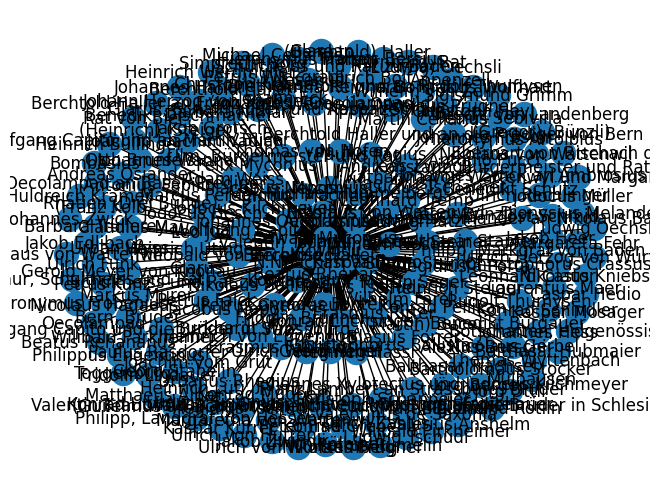

In [37]:
import csv
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a graph
G = nx.Graph()

# Read data from CSV file
with open('zwingli_letters_clean.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header row
    for row in reader:
        # Assuming the sender is in the second column and the receiver is in the third column
        if row[1] == "Zwingli" or row[2] == "Zwingli":
            if G.has_edge(row[1], row[2]):
                # we added this one before, just increase the weight by one
                G[row[1]][row[2]]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_edge(row[1], row[2], weight=1)

# Filter out nodes with degree less than a threshold (e.g., 2)
# deg = dict(nx.degree(G))  # Convert degree view to a dictionary
# to_remove = [n for n in deg if deg.get(n, 0) < 2]
# G.remove_nodes_from(to_remove)

# # Filter out edges with weight less than a threshold (e.g., 2)
# to_remove = [(n1, n2) for n1, n2, attr in G.edges(data=True) if attr.get('weight', 0) < 2]
# G.remove_edges_from(to_remove)

pos = nx.spring_layout(G, k=0.25)  # Adjust the 'k' parameter to your liking
weights = nx.get_edge_attributes(G, 'weight')

# Draw the graph with varying edge width based on weight
nx.draw(G, pos, with_labels=True, width=[v for v in weights.values()])

plt.show()
